# Выбор локации для скважины

Из трёх регионов необходимо выбрать наиболее прибыльный для добычи нефти. По всем регионам нам предоставлены данные о месторождениях, качестве нефти и запасах. Проанализируем возможную прибыль и риски техникой *Bootstrap*. Обучим модель машинного обучения, для определения лучшего региона.

Шаги для выбора локации:

- определим признаки для месторождений;
- построим модель и оценим объём запасов;
- выберем месторождение с лучшей оценкой.

## Загрузка и подготовка данных

- Загрузим данные.
- Проверим типы, пропуски и особенности.
- Выделим целевые и остальные признаки.
- Удалим лишнее.
- Поделим данные на обучающие и валидационные.
- Проведём масштабирование.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from scipy import stats as st
from sklearn.model_selection import train_test_split

In [2]:
df_list = []

In [3]:
df_list.append(pd.read_csv('datasets/geo_data_0.csv'))
df_list.append(pd.read_csv('datasets/geo_data_1.csv'))
df_list.append(pd.read_csv('datasets/geo_data_2.csv'))

In [4]:
df_list[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
df_list[0].head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [6]:
df_list[0]['id'].describe()

count     100000
unique     99990
top        fiKDv
freq           2
Name: id, dtype: object

In [7]:
df_list[0].duplicated(subset=['id'], keep=False).sum()

20

In [8]:
df_list[0][df_list[0].duplicated(subset=['id'], keep=False)==True].sort_values(by='id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


Обнаружились 20 дубликатов скважин, но с разными данными. Это менее 0.02%. Удалим эти противоречивые данные.

In [9]:
df_list[0] = df_list[0].drop_duplicates(subset=['id'], keep=False)

In [10]:
df_list[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99980 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99980 non-null  object 
 1   f0       99980 non-null  float64
 2   f1       99980 non-null  float64
 3   f2       99980 non-null  float64
 4   product  99980 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [11]:
df_list[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [12]:
df_list[1].head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [13]:
df_list[1]['id'].describe()

count     100000
unique     99996
top        wt4Uk
freq           2
Name: id, dtype: object

In [14]:
df_list[1].duplicated(subset=['id'], keep=False).sum()

8

Здесь также удалим дубликаты.

In [15]:
df_list[1] = df_list[1].drop_duplicates(subset=['id'], keep=False)

In [16]:
df_list[2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [17]:
df_list[2].head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [18]:
df_list[2]['id'].describe()

count     100000
unique     99996
top        VF7Jo
freq           2
Name: id, dtype: object

In [19]:
df_list[2].duplicated(subset=['id'], keep=False).sum()

8

In [20]:
df_list[2] = df_list[2].drop_duplicates(subset=['id'], keep=False)

Во всех датасетах есть ключевое поле id. Это уникальный идентификатор, который имеет 99.99% уникальных значений, не несущих количественных и категориальных данных. Это поле можно исключить из данных для построения модели.

In [21]:
for i in range(len(df_list)):
    df_list[i] = df_list[i].drop('id', axis=1)

In [22]:
df_list[0].head()

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


In [23]:
df_list[1].head()

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


In [24]:
df_list[2].head()

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


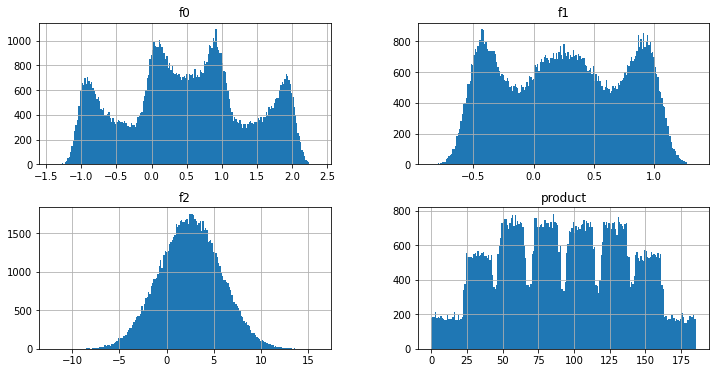

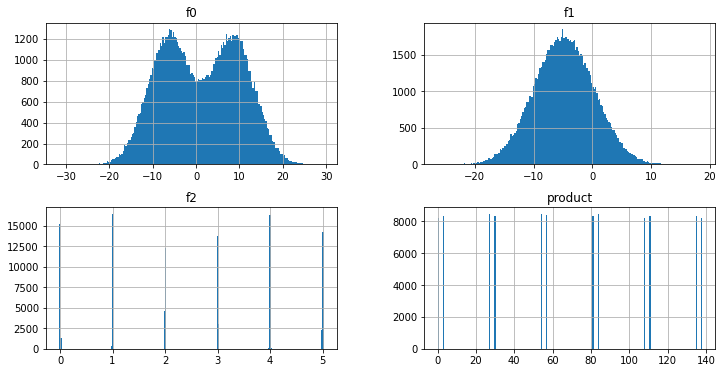

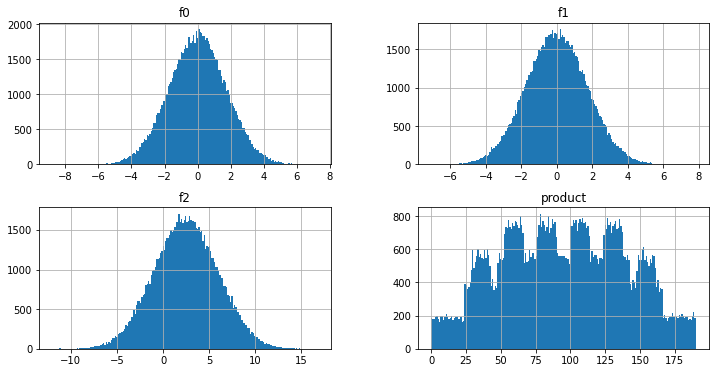

In [25]:
for df in df_list:
    df[['f0', 'f1', 'f2', 'product']].hist(bins=200, figsize=(12, 6))

Характеристики f0, f1, f2 имеют разный характер распределения и диапазоны в данных для разных участков. Возможно, они не являются аналогичными, то есть, возможно, это не одни и те же параметры. Поэтому не будем делать общую выборку из всех данных. Рассмотрим каждый участок отдельно.

Распределения на первый взгляд, не зная природы параметров, выглядят гармонично и не имеют аномалий (выбросов).

Мы имеем количественные признаки f0, f1, f2 и целевой количественный признак product.

### Выделим целевой признак

In [26]:
features_target_dict = []

In [27]:
for df in df_list:
    features_target_dict.append({'target': df['product'], 'features': df.drop('product', axis=1)})

### Разделение данных для тренировки и валидации

In [28]:
train_valid_dict = []

In [29]:
for item in features_target_dict:
    features_train, features_valid, target_train, target_valid = train_test_split(
        item['features'], item['target'], test_size=0.25, random_state=42)
    train_valid_dict.append({
        'features_train': features_train,
        'features_valid': features_valid,
        'target_train': target_train,
        'target_valid': target_valid
    })


In [30]:
train_valid_dict[0]['features_train'].shape, train_valid_dict[0]['target_train'].shape

((74985, 3), (74985,))

In [31]:
train_valid_dict[1]['features_train'].shape, train_valid_dict[0]['target_train'].shape

((74994, 3), (74985,))

In [32]:
train_valid_dict[2]['features_train'].shape, train_valid_dict[0]['target_train'].shape

((74994, 3), (74985,))

### Масштабирование

In [33]:
pd.options.mode.chained_assignment = None

Поля с количественными признаками

In [34]:
numeric = ['f0', 'f1', 'f2']

In [35]:
train_valid_dict[0]['features_train'].head()

,f0,f1,f2
1920,2.102576,0.086425,6.945367
60805,-1.044580,0.160883,-0.918005
4161,0.293768,-0.355387,3.063802
70697,-0.496395,1.009531,0.969264
25132,1.725086,0.048179,4.641441


In [36]:
for item in train_valid_dict:
    scaler = StandardScaler()
    scaler.fit(item['features_train'][numeric])
    item['features_train'][numeric] = scaler.transform(item['features_train'][numeric])
    item['features_valid'][numeric] = scaler.transform(item['features_valid'][numeric])

In [37]:
train_valid_dict[0]['features_train'].head()

,f0,f1,f2
1920,1.838916,-0.326535,1.361750
60805,-1.772036,-0.178945,-1.055053
4161,-0.236455,-1.202282,0.168753
70697,-1.143065,1.503222,-0.475002
25132,1.405795,-0.402344,0.653640


## Обучение и проверка модели

Обучим модели, предскажем запас сырья и рассчитаем ошибку для валидационных данных

In [38]:
for item in train_valid_dict:
    model = LinearRegression()
    model.fit(item['features_train'], item['target_train'])
    item['predicted_valid'] = pd.Series(data=model.predict(item['features_valid']), index=item['features_valid'].index)
    item['rmse'] = (mean_squared_error(item['target_valid'], item['predicted_valid']))**0.5

In [39]:
for i in range(len(train_valid_dict)):
    print('Регион', i)
    print('Средний запас предсказанного сырья:', train_valid_dict[i]['predicted_valid'].mean())
    print('RMSE:', train_valid_dict[i]['rmse'])
    print()        

Регион 0
Средний запас предсказанного сырья: 92.2865385223536
RMSE: 37.76114714593895

Регион 1
Средний запас предсказанного сырья: 69.16894101447984
RMSE: 0.892863589877732

Регион 2
Средний запас предсказанного сырья: 94.82069136328788
RMSE: 40.13115560413051



Данные показывают, что средний запас в двух регионах (0 и 2) заметно выше, чем в регионе 1, но при этом и ошибка RMSE также большая, что увеличит разброс в дальнейших расчётах.

## Подготовка к расчёту прибыли

Бюджет на разработку скважин в регионе.

In [40]:
REGION_BUDGET = 10 * 10 ** 9

При разведке региона исследуют 500 точек.

In [41]:
REGION_RESEARCH_POINTS = 500

С помощью машинного обучения выбирают 200 лучших для разработки.

In [42]:
REGION_BEST_POINTS = 200

При нынешних ценах один баррель сырья приносит 450 рублей дохода.

In [43]:
INCOME_PER_MILBARRELS = 450000

Доверительный интервал

In [44]:
CONFIDENCE_INTERVAL_PROBABILITY = 0.95

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%

In [45]:
BUSINESS_RISK = 0.025

Достаточный объём сырья для безубыточной разработки новой скважины

In [46]:
REQUIRED_PRODUCT = REGION_BUDGET / REGION_BEST_POINTS / INCOME_PER_MILBARRELS

In [47]:
REQUIRED_PRODUCT

111.11111111111111

Рассчитанный необходимый объём значительно выше средних предсказанных (92, 69, 95). Больше чем половина всех скважин в регионах имеют меньшие предсказанные запасы. Нет однозначного решения о принятии региона в разработку. Требуется дальнейшее рассмотрение доверительных интервалов прибыли и оценки рисков. 

## Расчёт прибыли и рисков 

Напишем функцию расчёта прибыли. Из переданных значений объёмов сырья выбираются лучшие значения, суммируются, расчитывается доход с них и вычитаются расходы.

In [48]:
def get_profit(target_product, predicted_product, best_count, price, budget):
    # рассчитывает прибыль 
    predicted_product_sorted = predicted_product.sort_values(ascending=False)
    predicted_product_best = predicted_product_sorted[:best_count]
    
    target_product_best = target_product.loc[predicted_product_best.index]
    target_product_sum = target_product_best.sum()

    return target_product_sum * price - budget

### Рассчитаем прибыль регионов в лоб

In [49]:
for i in range(len(train_valid_dict)):
    print('Регион', i)
    print('Прибыль:', get_profit(
        train_valid_dict[i]['target_valid'], 
        train_valid_dict[i]['predicted_valid'], 
        REGION_BEST_POINTS, INCOME_PER_MILBARRELS, REGION_BUDGET))
    print()

Регион 0
Прибыль: 3301821343.6462536

Регион 1
Прибыль: 2415086696.681511

Регион 2
Прибыль: 2103914701.2991962



### Рассмотрим распределение прибыли методом Bootstrap

Регион 0
Средняя прибыль: 402548603.15007055
Доверительный 95% интервал:
 - 2.5%: -106978012.94408746
 - 97.5%: 934997226.5603895
Риск убытков: 5.70%
!!! Риск убытков превысил порог 2.5%


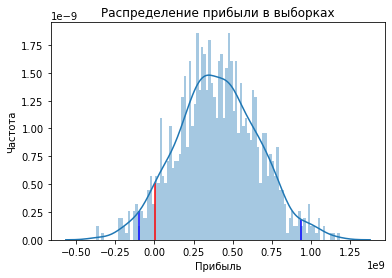


Регион 1
Средняя прибыль: 487080458.93470496
Доверительный 95% интервал:
 - 2.5%: 94507331.60732569
 - 97.5%: 897961236.3520374
Риск убытков: 0.90%


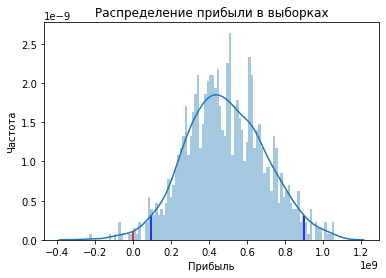


Регион 2
Средняя прибыль: 359534661.8230114
Доверительный 95% интервал:
 - 2.5%: -171589253.1912722
 - 97.5%: 841461811.3044116
Риск убытков: 8.30%
!!! Риск убытков превысил порог 2.5%


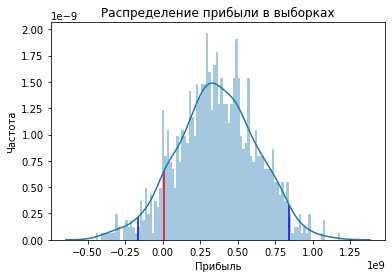


Лучший регион: 1
Средняя прибыль: 487080458.93470496


In [50]:
state = np.random.RandomState(42)

best_profit = 0
best_region = -1

for i in range(len(train_valid_dict)):
    # перебираем все регионы
    
    print('Регион', i)
    
    # предсказанная прибыль
    predicted_product = train_valid_dict[i]['predicted_valid']
    target_product = train_valid_dict[i]['target_valid']
    
    profits = []
    
    for n in range(1000):
        # сделаем серию подвыборок по заданному количеству точек
        subsample_product = predicted_product.sample(n=REGION_RESEARCH_POINTS, replace=False, random_state=state)
        # подсчитаем прибыль на полученной подвыборке
        profit = get_profit(target_product, subsample_product, REGION_BEST_POINTS, INCOME_PER_MILBARRELS, REGION_BUDGET)
        # соберём значения в список для анализа
        profits.append(profit)
    
    profits = pd.Series(profits)
    profit_mean = profits.mean()
    
    # доверительный интервал
    lower_percent = (1 - CONFIDENCE_INTERVAL_PROBABILITY) / 2
    upper_percent = (1 + CONFIDENCE_INTERVAL_PROBABILITY) / 2
    lower = profits.quantile(lower_percent)
    upper = profits.quantile(upper_percent)
    
    # вероятность того, что прибыль будет меньше 0 (доля случаев, где прибыль отрицательная)
    loss_probability = (profits < 0).mean()
  
    print(f'Средняя прибыль: {profit_mean}')
    print(f"Доверительный {CONFIDENCE_INTERVAL_PROBABILITY:.0%} интервал:")
    print(f" - {lower_percent:.1%}:", lower)
    print(f" - {upper_percent:.1%}:", upper)
    print(f"Риск убытков: {loss_probability:.2%}")
    
    if (loss_probability >= BUSINESS_RISK):
        print(f'!!! Риск убытков превысил порог {BUSINESS_RISK:.1%}')
    else:
        if (profit > best_profit):
            best_profit = profit_mean
            best_region = i

    plt.title("Распределение прибыли в выборках")
    plt.ylabel("Частота")
    plt.xlabel("Прибыль")
    ax = sns.distplot(profits, bins=100) 
    x = ax.lines[0].get_xdata()
    y = ax.lines[0].get_ydata()
    idx_zero = idx_lower = idx_upper = -1
    for i in range(len(x)):
        if x[i] >= lower and idx_lower==-1:
            idx_lower = i
        if x[i] >= upper and idx_upper==-1:
            idx_upper = i
        if x[i] >= 0 and idx_zero==-1:
            idx_zero = i
     
    ax.vlines(x[idx_lower], 0, y[idx_lower], color='blue', ls='solid')
    ax.vlines(x[idx_upper], 0, y[idx_upper], color='blue', ls='solid')
    ax.vlines(x[idx_zero], 0, y[idx_zero], color='red', ls='solid')
    plt.show()
    
    print()

print('Лучший регион:', best_region)
print('Средняя прибыль:', best_profit)

## Вывод 

Регионы 0 и 2 выпадают из рассмотрения после расчёта рисков, риски превышают пороговое значение. В регионе 1 самое большое значение средней прибыли после процедуры bootstrap. Таким образом, регион 1 по всем параметрам превзошёл 2 других.

Исходя из полученных значений для разработки рекомендован Регион 1. 